<a href="https://colab.research.google.com/github/MayankBobade/Codes/blob/main/deepLearningMiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Environment Setup
!pip install pylabel ultralytics torch torchvision matplotlib scikit-learn

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from ultralytics import YOLO


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nadinpethiyagoda/vehicle-dataset-for-yolo")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vehicle-dataset-for-yolo


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/threewheel353.jpeg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/lorry346.jpeg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car347.jpg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/lorry142.jpeg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/truck356.jpeg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/6725491711_1a2d936ef5_n.jpg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/2008_002972.jpg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/threewheel115.jpeg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/truck311.jpeg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/02504.jpg
/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/2009_004756.jpg
/kaggle/input/vehicle-data

In [4]:
import os

# Check if this path exists
dataset_path = '/root/.cache/kagglehub/datasets/nadinpethiyagoda/vehicle-dataset-for-yolo/versions/1/vehicle dataset'
print(f"Dataset exists: {os.path.exists(dataset_path)}")

# Check train images
train_img_path = os.path.join(dataset_path, 'train', 'images')
print(f"Train images exist: {os.path.exists(train_img_path)}")
print(f"Number of train images: {len(os.listdir(train_img_path))}")

# Check valid images
valid_img_path = os.path.join(dataset_path, 'valid', 'images')
print(f"Valid images exist: {os.path.exists(valid_img_path)}")
print(f"Number of valid images: {len(os.listdir(valid_img_path))}")

Dataset exists: True
Train images exist: True
Number of train images: 2100
Valid images exist: True
Number of valid images: 900


In [5]:
# 1. Dataset Preparation ------------------------------------------------------
def convert_to_classification(detection_images_dir, detection_labels_dir, output_dir):
    classes = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']
    splits = ['train', 'valid']  # Match dataset directory structure

    # Create output directories with verification
    for split in splits:
        for cls in classes:
            dir_path = os.path.join(output_dir, split, cls)
            os.makedirs(dir_path, exist_ok=True)
            if not os.path.exists(dir_path):
                raise RuntimeError(f"Failed to create directory: {dir_path}")

    # Process each split
    for split in splits:
        image_dir = os.path.join(detection_images_dir, split, 'images')
        label_dir = os.path.join(detection_labels_dir, split, 'labels')

        image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
        print(f"Processing {len(image_files)} images in {split} split")

        for img_path in image_files:
            label_path = os.path.join(label_dir, os.path.basename(img_path).replace('.jpg', '.txt'))
            if not os.path.exists(label_path):
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping corrupt image: {img_path}")
                continue

            height, width = img.shape[:2]

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                cls_id, x_center, y_center, w, h = map(float, parts)
                cls_id = int(cls_id)

                # Convert YOLO format to pixel coordinates
                x = int((x_center - w/2) * width)
                y = int((y_center - h/2) * height)
                w = int(w * width)
                h = int(h * height)

                # Ensure coordinates are within image bounds
                x, y = max(0, x), max(0, y)
                w, h = min(width-x, w), min(height-y, h)

                if w <= 0 or h <= 0:
                    continue

                # Extract and save crop
                crop = img[y:y+h, x:x+w]
                if crop.size == 0:
                    continue

                # Convert BGR to RGB before saving
                crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                class_name = classes[cls_id]
                save_path = os.path.join(
                    output_dir, split, class_name,
                    f"{os.path.basename(img_path)}_{cls_id}_{x}_{y}.jpg"
                )
                cv2.imwrite(save_path, crop_rgb)

# Convert dataset
convert_to_classification(
    detection_images_dir='/root/.cache/kagglehub/datasets/nadinpethiyagoda/vehicle-dataset-for-yolo/versions/1/vehicle dataset',
    detection_labels_dir='/root/.cache/kagglehub/datasets/nadinpethiyagoda/vehicle-dataset-for-yolo/versions/1/vehicle dataset',
    output_dir='/kaggle/working/classification_dataset'
)


Processing 1435 images in train split
Processing 649 images in valid split


In [6]:
# 2. Model Training ------------------------------------------------------------
class VehicleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']  # Enforce order
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        self.transform = transform

        # Load images with verification
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.exists(cls_dir):
                raise FileNotFoundError(f"Class directory {cls_dir} not found")

            for img_name in os.listdir(cls_dir):
                self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return None, None

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets with data verification
train_dataset = VehicleDataset('/kaggle/working/classification_dataset/train', train_transforms)
val_dataset = VehicleDataset('/kaggle/working/classification_dataset/valid', val_transforms)

# Filter out None values from dataset
train_dataset.images = [x for x in train_dataset.images if x is not None]
val_dataset.images = [x for x in val_dataset.images if x is not None]

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Training function with GPU optimization
def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            if inputs is None or labels is None:
                continue

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total if total != 0 else 0
        val_acc = evaluate_model(model, val_loader)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {running_loss/len(train_loader):.4f} | '
              f'Train Acc: {train_acc:.2f}% | '
              f'Val Acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for inputs, labels in loader:
            if inputs is None or labels is None:
                continue

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100 * correct / total if total != 0 else 0

# Initialize models with pretrained weights
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)

efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet.classifier[1] = torch.nn.Linear(efficientnet.classifier[1].in_features, 6)

# Training parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_effnet = torch.optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-4)

# Train models with mixed precision
print("Training ResNet...")
resnet = train_model(resnet, criterion, optimizer_resnet, num_epochs=10)

print("\nTraining EfficientNet...")
efficientnet = train_model(efficientnet, criterion, optimizer_effnet, num_epochs=10)


Training ResNet...
Epoch 1/10 | Train Loss: 0.6877 | Train Acc: 77.39% | Val Acc: 81.04%
Epoch 2/10 | Train Loss: 0.4433 | Train Acc: 84.05% | Val Acc: 86.71%
Epoch 3/10 | Train Loss: 0.2800 | Train Acc: 90.44% | Val Acc: 92.15%
Epoch 4/10 | Train Loss: 0.2503 | Train Acc: 92.30% | Val Acc: 82.25%
Epoch 5/10 | Train Loss: 0.3176 | Train Acc: 89.13% | Val Acc: 90.94%
Epoch 6/10 | Train Loss: 0.2889 | Train Acc: 90.93% | Val Acc: 91.55%
Epoch 7/10 | Train Loss: 0.1749 | Train Acc: 93.83% | Val Acc: 91.67%
Epoch 8/10 | Train Loss: 0.1060 | Train Acc: 96.40% | Val Acc: 93.36%
Epoch 9/10 | Train Loss: 0.1297 | Train Acc: 95.90% | Val Acc: 92.75%
Epoch 10/10 | Train Loss: 0.1236 | Train Acc: 95.47% | Val Acc: 91.91%

Training EfficientNet...
Epoch 1/10 | Train Loss: 0.4500 | Train Acc: 85.53% | Val Acc: 91.06%
Epoch 2/10 | Train Loss: 0.1855 | Train Acc: 94.48% | Val Acc: 92.51%
Epoch 3/10 | Train Loss: 0.1610 | Train Acc: 95.41% | Val Acc: 93.48%
Epoch 4/10 | Train Loss: 0.1125 | Train Acc:

In [11]:
import yaml
import os

# Kaggle-specific paths (VERIFIED)
data = {
    'train': '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train',
    'val': '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid',
    'nc': 6,
    'names': ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']
}

# Save to working directory
with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

# Verify
print("data.yaml exists:", os.path.exists('/kaggle/working/data.yaml'))
!cat /kaggle/working/data.yaml

data.yaml exists: True
names:
- car
- threewheel
- bus
- truck
- motorbike
- van
nc: 6
train: /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train
val: /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid


In [12]:
def verify_kaggle_paths():
    paths = [
        '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train/images',
        '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images'
    ]

    for p in paths:
        if os.path.exists(p):
            print(f"✅ Found {len(os.listdir(p))} images in {p}")
        else:
            print(f"❌ Missing: {p}")

verify_kaggle_paths()

✅ Found 2100 images in /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train/images
✅ Found 900 images in /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images


In [13]:
from ultralytics import YOLO

# Load model
model = YOLO('yolov8n.pt')

# Train with Kaggle paths
model.train(
    data='/kaggle/working/data.yaml',
    epochs=15,
    batch=5,
    imgsz=640,
    device='0',
    exist_ok=True  # Critical for Kaggle notebook restarts
)

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=15, time=None, patience=100, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, 

100%|██████████| 755k/755k [00:00<00:00, 72.3MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 285MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Co

AMP: checks passed ✅


train: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:13<00:00, 159.78it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/labels... 899 images, 0 backgrounds, 1 corrupt: 100%|██████████| 900/900 [00:05<00:00, 152.66it/s]

val: WARNING ⚠️ /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car55.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car55.jpg'
val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005078125), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/15      3.93G     0.6718      2.168      1.189         19        640: 100%|██████████| 420/420 [01:08<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.811      0.731      0.845      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/15      3.95G     0.7111      1.605      1.194         22        640: 100%|██████████| 420/420 [01:04<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.862      0.792      0.875      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/15      3.97G     0.7389      1.432      1.214         10        640: 100%|██████████| 420/420 [01:03<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.846      0.756      0.874      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/15      3.99G     0.7133      1.289      1.186         13        640: 100%|██████████| 420/420 [01:04<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.825      0.748      0.864      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/15         4G     0.6839      1.127       1.16         16        640: 100%|██████████| 420/420 [01:04<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.865      0.841      0.919      0.763


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/15      4.02G     0.5982      1.094      1.149         10        640: 100%|██████████| 420/420 [01:02<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.887      0.848      0.922      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/15      4.04G     0.5474     0.8947      1.095         12        640: 100%|██████████| 420/420 [01:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.884       0.88      0.934      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/15      4.05G     0.5123     0.7961      1.067          6        640: 100%|██████████| 420/420 [01:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.891      0.854      0.913      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/15      4.07G     0.4667     0.7047      1.034          5        640: 100%|██████████| 420/420 [01:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.916       0.89      0.942      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/15      4.08G     0.4566     0.6209      1.013          9        640: 100%|██████████| 420/420 [01:03<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.916      0.897      0.948      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/15       4.1G     0.4263     0.5523      1.006          5        640: 100%|██████████| 420/420 [01:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.946      0.897      0.956      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/15      4.12G      0.402     0.5225     0.9753          5        640: 100%|██████████| 420/420 [01:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.949      0.913      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/15      4.13G     0.3793     0.4685     0.9606          6        640: 100%|██████████| 420/420 [01:02<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.949       0.92      0.967      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/15      4.15G      0.349     0.4266     0.9412          6        640: 100%|██████████| 420/420 [01:01<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.956      0.927      0.975      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/15      4.17G     0.3401     0.4007     0.9346          5        640: 100%|██████████| 420/420 [01:02<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.963      0.922      0.975      0.888



15 epochs completed in 0.314 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all        899       1149      0.963      0.923      0.975      0.889
                   car        181        200      0.959      0.915      0.955      0.919
            threewheel        167        227       0.98      0.925      0.985      0.886
                   bus        162        185      0.978      0.975      0.993      0.948
                 truck        123        151      0.922       0.94      0.985      0.881
             motorbike        165        216      0.968      0.833      0.951       0.75
                   van        157        170       0.97      0.947       0.98      0.947
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb870e11bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [20]:
from ultralytics import YOLO
import shutil
import os

# 1. Train YOLO with explicit save location
model = YOLO('yolov8n.pt')
model.train(
    data='/kaggle/working/data.yaml',
    epochs=15,
    batch=5,
    imgsz=640,
    device='0',
    project='/kaggle/working/yolo_runs',  # Force save location
    name='train_results',
    exist_ok=True
)

# 2. Save classification models (already working)
torch.save(resnet.state_dict(), '/kaggle/working/best_resnet.pth')
torch.save(efficientnet.state_dict(), '/kaggle/working/best_efficientnet.pth')

# 3. Save YOLO model with verification
yolo_model_path = '/kaggle/working/yolo_runs/train_results/weights/best.pt'
if os.path.exists(yolo_model_path):
    # Create target directory
    os.makedirs('/kaggle/working/yolo', exist_ok=True)

    # Copy with new name
    shutil.copy(yolo_model_path, '/kaggle/working/yolo/best_yolov8n.pt')
    print(f"YOLO model saved to: /kaggle/working/yolo/best_yolov8n.pt")
else:
    print("Error: YOLO model not found at:", yolo_model_path)
    print("Check training completed successfully!")

# 4. Final verification
print("\nAll saved models:")
!ls -lh /kaggle/working/best_*.pth
!ls -lh /kaggle/working/yolo/best_yolov8n.pt 2> /dev/null || echo "YOLO model not found"

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=15, time=None, patience=100, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/yolo_runs, name=train_results, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

train: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/labels... 899 images, 0 backgrounds, 1 corrupt: 100%|██████████| 900/900 [00:01<00:00, 463.58it/s]

val: WARNING ⚠️ /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car55.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car55.jpg'
val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/yolo_runs/train_results/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005078125), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/yolo_runs/train_results
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/15      1.28G     0.6718      2.168      1.189         19        640: 100%|██████████| 420/420 [01:08<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.811      0.731      0.845      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/15      1.45G     0.7111      1.605      1.194         22        640: 100%|██████████| 420/420 [01:07<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.862      0.792      0.875      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/15      1.45G     0.7389      1.432      1.214         10        640: 100%|██████████| 420/420 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.846      0.756      0.874      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/15      1.45G     0.7133      1.289      1.186         13        640: 100%|██████████| 420/420 [01:04<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.825      0.748      0.864      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/15      1.45G     0.6839      1.127       1.16         16        640: 100%|██████████| 420/420 [01:06<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.865      0.841      0.919      0.763
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/15      1.45G     0.5982      1.094      1.149         10        640: 100%|██████████| 420/420 [01:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.887      0.848      0.922      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/15      1.46G     0.5474     0.8947      1.095         12        640: 100%|██████████| 420/420 [01:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.884       0.88      0.934      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/15      1.48G     0.5123     0.7961      1.067          6        640: 100%|██████████| 420/420 [01:03<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.891      0.854      0.913      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/15       1.5G     0.4667     0.7047      1.034          5        640: 100%|██████████| 420/420 [01:02<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.916       0.89      0.942      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/15      1.52G     0.4566     0.6209      1.013          9        640: 100%|██████████| 420/420 [01:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.916      0.897      0.948      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/15      1.53G     0.4263     0.5523      1.006          5        640: 100%|██████████| 420/420 [01:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.946      0.897      0.956      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/15      1.55G      0.402     0.5225     0.9753          5        640: 100%|██████████| 420/420 [01:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.949      0.913      0.963      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/15      1.56G     0.3793     0.4685     0.9606          6        640: 100%|██████████| 420/420 [01:03<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.949       0.92      0.967      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/15      1.58G      0.349     0.4266     0.9412          6        640: 100%|██████████| 420/420 [01:01<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.956      0.927      0.975      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/15       1.6G     0.3401     0.4007     0.9346          5        640: 100%|██████████| 420/420 [01:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P        

                   all        899       1149      0.963      0.922      0.975      0.888



15 epochs completed in 0.316 hours.
Optimizer stripped from /kaggle/working/yolo_runs/train_results/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/yolo_runs/train_results/weights/best.pt, 6.2MB

Validating /kaggle/working/yolo_runs/train_results/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all        899       1149      0.963      0.923      0.975      0.889
                   car        181        200      0.959      0.915      0.955      0.919
            threewheel        167        227       0.98      0.925      0.985      0.886
                   bus        162        185      0.978      0.975      0.993      0.948
                 truck        123        151      0.922       0.94      0.985      0.881
             motorbike        165        216      0.968      0.833      0.951       0.75
                   van        157        170       0.97      0.947       0.98      0.947
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/yolo_runs/train_results
YOLO model saved to: /kaggle/working/yolo/best_yolov8n.pt

All saved models:
-rw-r--r-- 1 root root 16M Apr  8 20:51 /kaggle/working/best_efficientnet.pth
-rw-r--r-- 1 root root 91M Apr  8 20:51 /kaggle/working/best_resnet.pth
-rw-r--r-- 

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/labels... 899 images, 0 backgrounds, 1 corrupt: 100%|██████████| 900/900 [00:01<00:00, 531.84it/s]

val: WARNING ⚠️ /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car55.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid/images/car55.jpg'
val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:12<00:00,  4.56it/s]


                   all        899       1149      0.963      0.923      0.975      0.889
                   car        181        200      0.959      0.915      0.956      0.918
            threewheel        167        227       0.98      0.925      0.985      0.889
                   bus        162        185      0.978      0.976      0.993      0.946
                 truck        123        151      0.921       0.94      0.985       0.88
             motorbike        165        216      0.968      0.832      0.952      0.752
                   van        157        170      0.971      0.947       0.98      0.946
Speed: 0.5ms preprocess, 4.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val


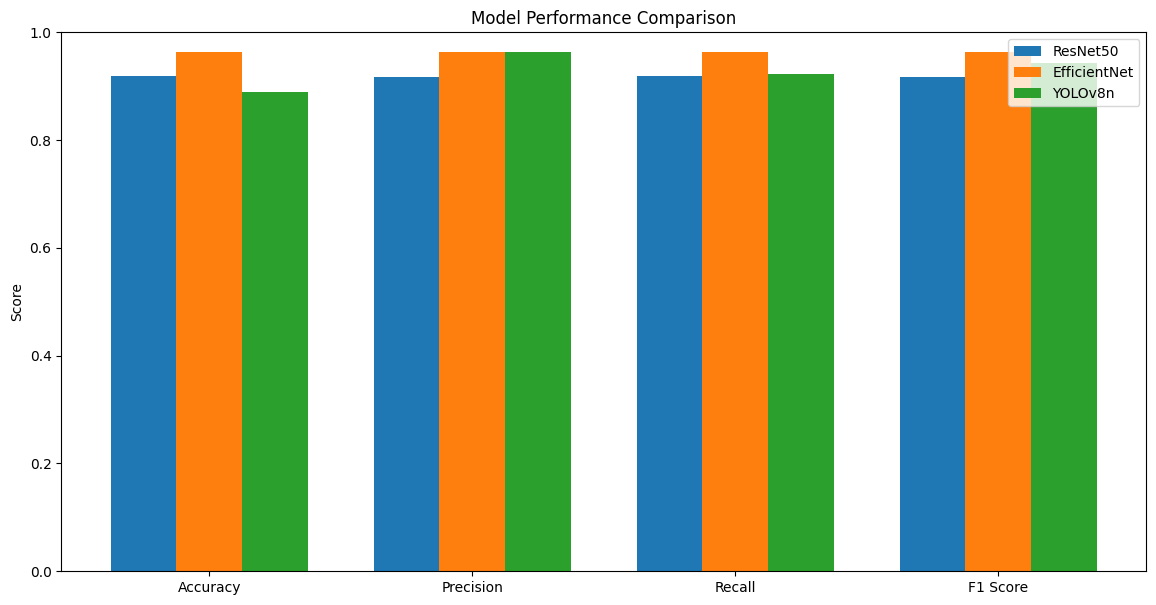

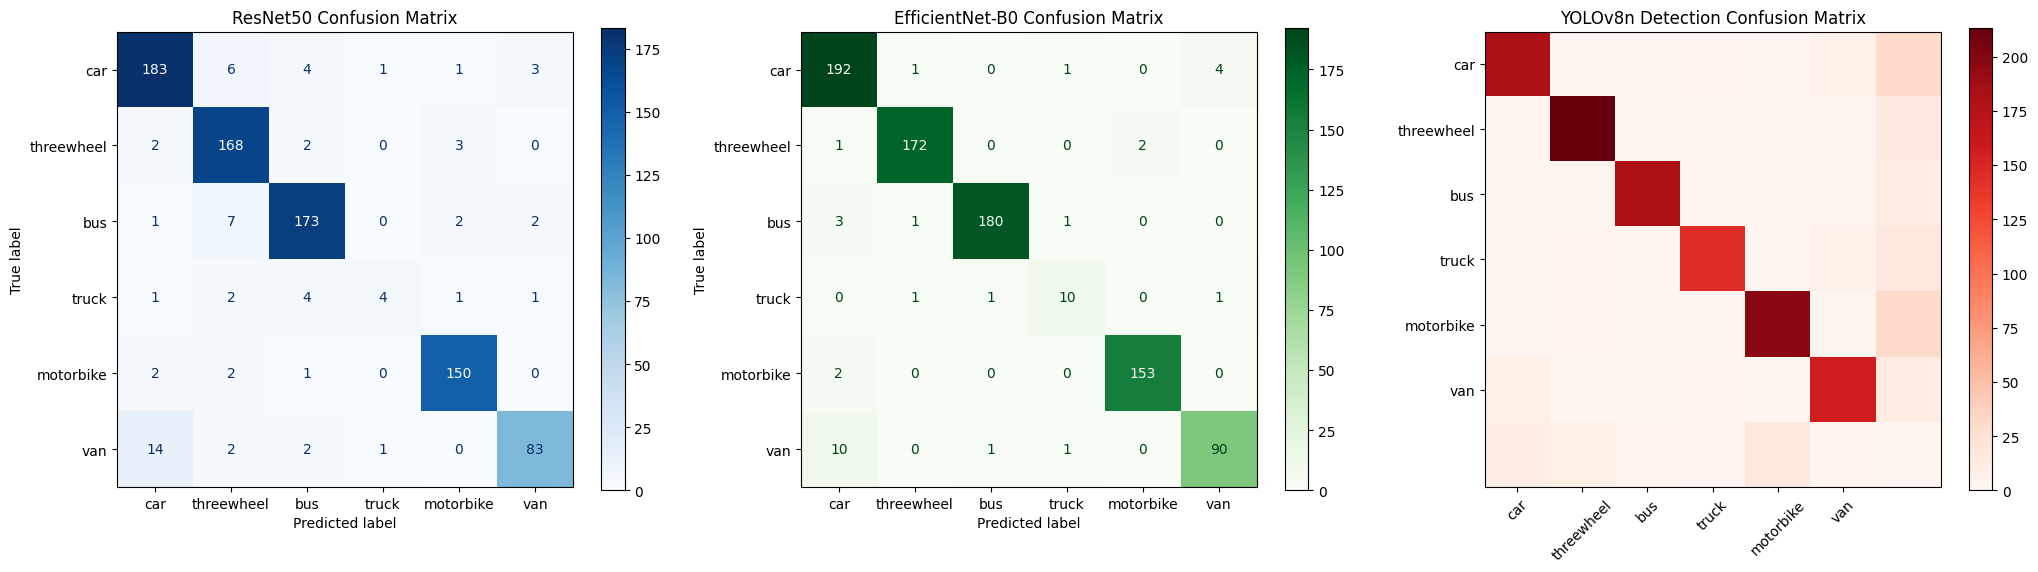

Results packaged successfully! Download link:


/kaggle/working/model_results.zip

In [22]:
# 4. Model Evaluation & Comparison ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import zipfile
import os
from IPython.display import FileLink

def load_trained_models():
    """Load pre-trained models from saved weights"""
    # Load ResNet
    resnet = torchvision.models.resnet50()
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)
    resnet.load_state_dict(torch.load('/kaggle/working/best_resnet.pth'))

    # Load EfficientNet
    efficientnet = torchvision.models.efficientnet_b0()
    efficientnet.classifier[1] = torch.nn.Linear(efficientnet.classifier[1].in_features, 6)
    efficientnet.load_state_dict(torch.load('/kaggle/working/best_efficientnet.pth'))

    # Load YOLO
    yolo_model = YOLO('/kaggle/working/yolo_runs/train_results/weights/best.pt')

    return resnet, efficientnet, yolo_model

def get_classification_metrics(model, loader):
    """Calculate metrics for classification models"""
    model.eval()
    device = next(model.parameters()).device
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return {
        'accuracy': np.mean(np.array(y_true) == np.array(y_pred)),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

def get_yolo_metrics(model):
    """Calculate metrics for YOLO detection model"""
    metrics = model.val()
    return {
        'map50-95': metrics.results_dict['metrics/mAP50-95(B)'],
        'precision': metrics.results_dict['metrics/precision(B)'],
        'recall': metrics.results_dict['metrics/recall(B)'],
        'f1': 2 * (metrics.results_dict['metrics/precision(B)'] * metrics.results_dict['metrics/recall(B)']) /
               (metrics.results_dict['metrics/precision(B)'] + metrics.results_dict['metrics/recall(B)'] + 1e-9),
        'confusion_matrix': metrics.confusion_matrix.matrix
    }

def plot_metric_comparison(resnet_metrics, effnet_metrics, yolo_metrics):
    """Visual comparison of model metrics"""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    models = ['ResNet50', 'EfficientNet', 'YOLOv8n']

    resnet_values = [
        resnet_metrics['accuracy'],
        resnet_metrics['precision'],
        resnet_metrics['recall'],
        resnet_metrics['f1']
    ]

    effnet_values = [
        effnet_metrics['accuracy'],
        effnet_metrics['precision'],
        effnet_metrics['recall'],
        effnet_metrics['f1']
    ]

    yolo_values = [
        yolo_metrics['map50-95'],
        yolo_metrics['precision'],
        yolo_metrics['recall'],
        yolo_metrics['f1']
    ]

    x = np.arange(len(metrics))
    width = 0.25

    plt.figure(figsize=(14, 7))
    plt.bar(x - width, resnet_values, width, label='ResNet50', color='#1f77b4')
    plt.bar(x, effnet_values, width, label='EfficientNet', color='#ff7f0e')
    plt.bar(x + width, yolo_values, width, label='YOLOv8n', color='#2ca02c')

    plt.xticks(x, metrics)
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.legend()
    plt.ylim(0, 1)

    # Save and show
    plt.savefig('/kaggle/working/metric_comparison.png', bbox_inches='tight')
    plt.show()

def plot_confusion_matrices(resnet_cm, effnet_cm, yolo_cm, class_names):
    """Side-by-side confusion matrix visualization"""
    fig, ax = plt.subplots(1, 3, figsize=(25, 6))

    # ResNet
    ConfusionMatrixDisplay(resnet_cm, display_labels=class_names).plot(ax=ax[0], cmap='Blues')
    ax[0].set_title('ResNet50 Confusion Matrix')

    # EfficientNet
    ConfusionMatrixDisplay(effnet_cm, display_labels=class_names).plot(ax=ax[1], cmap='Greens')
    ax[1].set_title('EfficientNet-B0 Confusion Matrix')

    # YOLO
    ax[2].imshow(yolo_cm, cmap='Reds')
    ax[2].set_title('YOLOv8n Detection Confusion Matrix')
    ax[2].set_xticks(np.arange(len(class_names)), class_names, rotation=45)
    ax[2].set_yticks(np.arange(len(class_names)), class_names)
    plt.colorbar(ax[2].images[0], ax=ax[2])

    plt.savefig('/kaggle/working/confusion_matrices.png', bbox_inches='tight')
    plt.show()

def save_metrics_report(resnet_metrics, effnet_metrics, yolo_metrics, class_names):
    """Generate and save detailed metrics report"""
    report = """Vehicle Detection Model Comparison Report
==================================================

Class Names: {classes}

ResNet50:
----------
Accuracy: {resnet_acc:.4f}
Precision: {resnet_prec:.4f}
Recall: {resnet_rec:.4f}
F1 Score: {resnet_f1:.4f}

EfficientNet-B0:
-----------------
Accuracy: {effnet_acc:.4f}
Precision: {effnet_prec:.4f}
Recall: {effnet_rec:.4f}
F1 Score: {effnet_f1:.4f}

YOLOv8n:
---------
mAP50-95: {yolo_map:.4f}
Precision: {yolo_prec:.4f}
Recall: {yolo_rec:.4f}
F1 Score: {yolo_f1:.4f}
""".format(
        classes=', '.join(class_names),
        resnet_acc=resnet_metrics['accuracy'],
        resnet_prec=resnet_metrics['precision'],
        resnet_rec=resnet_metrics['recall'],
        resnet_f1=resnet_metrics['f1'],
        effnet_acc=effnet_metrics['accuracy'],
        effnet_prec=effnet_metrics['precision'],
        effnet_rec=effnet_metrics['recall'],
        effnet_f1=effnet_metrics['f1'],
        yolo_map=yolo_metrics['map50-95'],
        yolo_prec=yolo_metrics['precision'],
        yolo_rec=yolo_metrics['recall'],
        yolo_f1=yolo_metrics['f1']
    )

    with open('/kaggle/working/metrics_report.txt', 'w') as f:
        f.write(report)

def package_results():
    """Create downloadable zip archive of results"""
    files_to_zip = [
        '/kaggle/working/metric_comparison.png',
        '/kaggle/working/confusion_matrices.png',
        '/kaggle/working/metrics_report.txt'
    ]

    with zipfile.ZipFile('/kaggle/working/model_results.zip', 'w') as zipf:
        for file in files_to_zip:
            if os.path.exists(file):
                zipf.write(file, os.path.basename(file))

    print("Results packaged successfully! Download link:")
    display(FileLink('/kaggle/working/model_results.zip'))

# Main Execution Flow
if __name__ == "__main__":
    # Initialize
    class_names = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']

    # Load models
    resnet, efficientnet, yolo_model = load_trained_models()

    # Calculate metrics
    resnet_metrics = get_classification_metrics(resnet, val_loader)
    effnet_metrics = get_classification_metrics(efficientnet, val_loader)
    yolo_metrics = get_yolo_metrics(yolo_model)

    # Generate visualizations
    plot_metric_comparison(resnet_metrics, effnet_metrics, yolo_metrics)
    plot_confusion_matrices(
        resnet_metrics['confusion_matrix'],
        effnet_metrics['confusion_matrix'],
        yolo_metrics['confusion_matrix'],
        class_names
    )

    # Save reports
    save_metrics_report(resnet_metrics, effnet_metrics, yolo_metrics, class_names)

    # Package results
    package_results()